In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn import linear_model
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cross_validation import StratifiedKFold
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import KFold
import sklearn.ensemble as ske
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasRegressor
from itertools import cycle
from sklearn.model_selection import KFold

LISTINGSFILE = 'listings_London.csv'
#выбор нескольких фич, которые очевидны для прогнозирования цены листинга
cols = ['price',
        'accommodates',
        'bedrooms',
        'beds',
        'neighbourhood_cleansed',
        'room_type',
        'cancellation_policy',
        'instant_bookable',
        'reviews_per_month',
        'number_of_reviews',
        'availability_30',
        'review_scores_rating'
        ]

df = pd.read_csv(LISTINGSFILE, usecols=cols)


In [3]:
df

,neighbourhood_cleansed,room_type,accommodates,bedrooms,beds,price,availability_30,number_of_reviews,review_scores_rating,instant_bookable,cancellation_policy,reviews_per_month
0,Haringey,Private room,1,1.0,1.0,$30.00,12,17,91.0,f,flexible,1.42
1,Haringey,Entire home/apt,4,2.0,2.0,$150.00,0,0,NaN,t,strict,NaN
2,Southwark,Entire home/apt,4,2.0,2.0,$87.00,1,11,91.0,f,moderate,6.23
3,Southwark,Entire home/apt,6,4.0,3.0,$100.00,0,3,100.0,t,moderate,0.12
4,Kensington and Chelsea,Private room,2,1.0,1.0,$35.00,0,33,97.0,f,strict,1.94
5,Hackney,Entire home/apt,3,1.0,2.0,$118.00,26,22,93.0,f,flexible,1.80
6,Merton,Entire home/apt,3,1.0,1.0,$75.00,11,18,93.0,f,strict,1.17
7,Camden,Entire home/apt,2,1.0,1.0,$100.00,0,7,100.0,t,moderate,1.67
8,Camden,Private room,2,1.0,1.0,$55.00,30,0,NaN,f,flexible,NaN
9,Hackney,Entire home/apt,4,1.0,2.0,$80.00,0,5,96.0,f,flexible,0.35


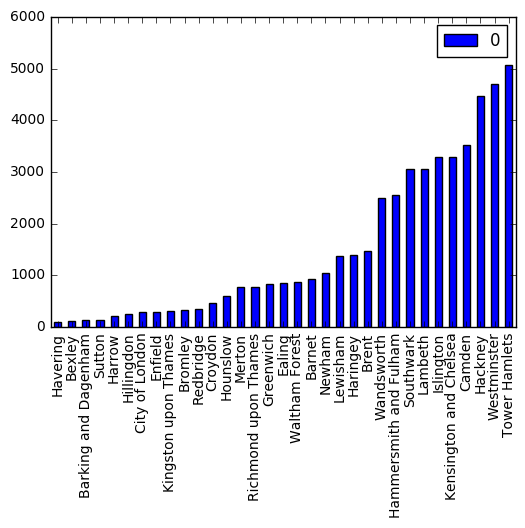

In [4]:
nb_counts = Counter(df.neighbourhood_cleansed)
tdf = pd.DataFrame.from_dict(nb_counts, orient='index').sort_values(by=0)
tdf.plot(kind='bar')

In [5]:
#удаление строк с  'плохими' значениями
df['reviews_per_month'].fillna(0, inplace=True)
#df = df[df.bedrooms != 0]
#df = df[df.beds != 0]
df = df[df.price != 0]
df = df.dropna(axis=0)

In [6]:
df.describe()

,accommodates,bedrooms,beds,availability_30,number_of_reviews,review_scores_rating,reviews_per_month
count,33641.000000,33641.000000,33641.000000,33641.000000,33641.000000,33641.000000,33641.000000
mean,3.112095,1.325971,1.725365,10.107191,16.704111,91.033887,1.442539
std,1.894939,0.787223,1.240201,10.848971,27.561575,10.464894,1.476633
min,1.000000,0.000000,1.000000,0.000000,1.000000,20.000000,0.020000
25%,2.000000,1.000000,1.000000,0.000000,2.000000,87.000000,0.390000
50%,2.000000,1.000000,1.000000,6.000000,7.000000,93.000000,0.970000
75%,4.000000,2.000000,2.000000,19.000000,19.000000,100.000000,2.000000
max,16.000000,10.000000,16.000000,30.000000,376.000000,100.000000,21.220000


In [7]:
df = df[df.bedrooms == 1]
#удаление $ для работы с ценой
df['price'] = df['price'].replace('[\$,)]','',  \
        regex=True).replace('[(]','-', regex=True).astype(float)

In [8]:
# замена boolean на 1 и 0
n_dummies = pd.get_dummies(df.neighbourhood_cleansed)
rt_dummies = pd.get_dummies(df.room_type)
xcl_dummies = pd.get_dummies(df.cancellation_policy)

ib_dummies = pd.get_dummies(df.instant_bookable, prefix="instant")
ib_dummies = ib_dummies.drop('instant_f', axis=1)

alldata = pd.concat((df.drop(['neighbourhood_cleansed', \
    'room_type', 'cancellation_policy', 'instant_bookable'], axis=1), \
    n_dummies.astype(int), rt_dummies.astype(int), \
    xcl_dummies.astype(int), ib_dummies.astype(int)), \
    axis=1)
allcols = alldata.columns

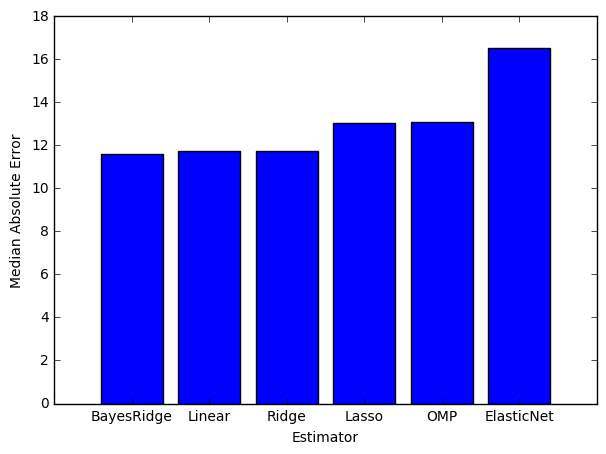

In [9]:
# сравним 6 линейных моделей по Median Absolute Error
rs = 1
ests = [ linear_model.LinearRegression(), linear_model.Ridge(),
        linear_model.Lasso(), linear_model.ElasticNet(),
        linear_model.BayesianRidge(), linear_model.OrthogonalMatchingPursuit() ]
ests_labels = np.array(['Linear', 'Ridge', 'Lasso', 'ElasticNet', 'BayesRidge', 'OMP'])
errvals = np.array([])

X_train, X_test, y_train, y_test = train_test_split(alldata.drop(['price'], axis=1),
                                                    alldata.price, test_size=0.2, random_state=20)

for e in ests:
    e.fit(X_train, y_train)
    this_err = metrics.median_absolute_error(y_test, e.predict(X_test))
    errvals = np.append(errvals, this_err)

pos = np.arange(errvals.shape[0])
srt = np.argsort(errvals)
plt.figure(figsize=(7,5))
plt.bar(pos, errvals[srt], align='center')
plt.xticks(pos, ests_labels[srt])
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')

In [10]:
# выбрали лин рег

regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# The coefficients
#print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regr.predict(X_test) - y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(X_test, y_test))

Mean squared error: 1054.81
Variance score: 0.44


In [11]:
# import the machine learning library that holds the randomforest
import sklearn.ensemble as ske

#instantiate and fit our model
results_rf = ske.RandomForestRegressor(n_estimators=100).fit(X_test, y_test)

# Score the results
score = results_rf.score(X_test, y_test)
print ("Mean accuracy of Random Forest Predictions on the data was: {0}".format(score))

Mean accuracy of Random Forest Predictions on the data was: 0.9100092550005592


In [12]:
print("error price: %.2f" % this_err)

error price: 13.07


NN

In [13]:
x = alldata.values[:, 0:12]
y = alldata.values[:, 6]

In [14]:
from keras.callbacks import Callback
from keras.callbacks import History
dataset1 = x
dataset2 = y
X, Y = dataset1, dataset2
train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=0.1, random_state=0)

In [15]:
X_train = train_X#np.array(x, ndmin=2).T
Y_train = train_y#np.array(y, ndmin=2).T

model = Sequential()

model.add(Dense(50, input_dim=12, init='normal', activation='relu')) # input layers
model.add(Dense(50, init='normal', activation='relu')) # output layers
#model.add(Dropout(0.5))
model.add(Dense(1, init='normal'))
# Compile model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
# Train the keras model
hist = model.fit(train_X, train_y, verbose=1,  batch_size=10, nb_epoch=30)
#model.fit(train_X, train_y, verbose=0, callbacks=[history], batch_size=10, nb_epoch=1)

# Test the model. Print the accuracy on the test data
loss, score = model.evaluate(test_X, test_y, verbose=0)
#print("score is {:.4f}".format(score))
print("Loss is {:.4f}".format(loss))

Epoch 1/30
20849/20849 [==============================] - 8s - loss: 195.4434 - acc: 0.5431     
Epoch 2/30
20849/20849 [==============================] - 7s - loss: 2.0872 - acc: 0.8619     
Epoch 3/30
20849/20849 [==============================] - 8s - loss: 10.4943 - acc: 0.7612     
Epoch 4/30
20849/20849 [==============================] - 8s - loss: 5.9863 - acc: 0.6799     
Epoch 5/30
20849/20849 [==============================] - 7s - loss: 0.7392 - acc: 0.9365     
Epoch 6/30
20849/20849 [==============================] - 8s - loss: 0.7911 - acc: 0.9110     
Epoch 7/30
20849/20849 [==============================] - 8s - loss: 0.3702 - acc: 0.9442     
Epoch 8/30
20849/20849 [==============================] - 7s - loss: 0.0092 - acc: 0.9944     
Epoch 9/30
20849/20849 [==============================] - 7s - loss: 0.0244 - acc: 0.9854     
Epoch 10/30
20849/20849 [==============================] - 7s - loss: 0.2708 - acc: 0.9644     
Epoch 11/30
20849/20849 [=====================

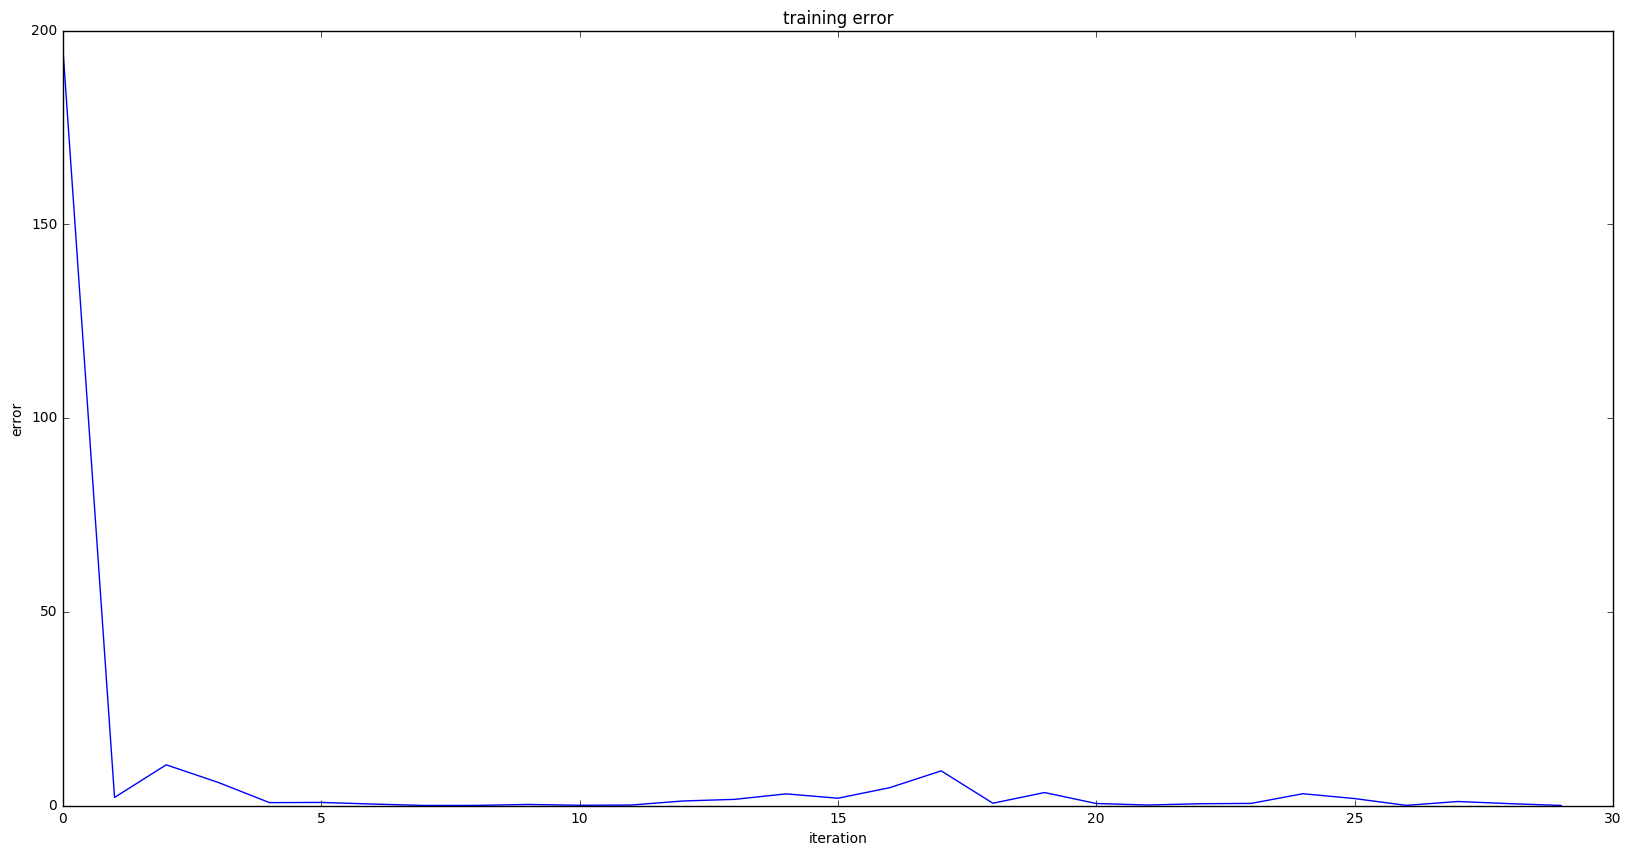

In [16]:
loss_list = hist.history['loss']
plt.figure(figsize=(20, 10))
plt.plot(loss_list)
plt.ylabel('error')
plt.xlabel('iteration')
plt.title('training error')
plt.show()

In [17]:
k = 10

predicted = model.predict_proba(test_X,verbose=0)
y_true = test_y
y_pred = predicted
print('Real values from test_y', y_true[:k].reshape(1,k)) 
print('Predicated values on test', y_pred[:k].reshape(1,k))

Real values from test_y [[ 100.   93.   90.  100.   80.  100.   73.   99.   60.   97.]]
Predicated values on test [[ 100.0364151    93.00957489   90.05020905  100.05595398   80.03058624
   100.02468872   73.04193878   99.02016449   60.05912399   97.05423737]]


/home/ivan/miniconda3/envs/fhm/lib/python3.5/site-packages/keras/models.py:792: UserWarning: Network returning invalid probability values. The last layer might not normalize predictions into probabilities (like softmax or sigmoid would).
  warnings.warn('Network returning invalid probability values. '


RandomForestRegressor

In [21]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(n_estimators = 100) 
clf.fit(train_X, train_y)
predict = clf.predict(test_X)
print(predict)
print(test_y)

[ 100.   93.   90. ...,   89.   95.   92.]
[ 100.   93.   90. ...,   89.   95.   92.]


In [37]:
print(clf.score(test_X, test_y))
print(clf.score(test_X, predict))

0.999932094013
1.0


Проверям на Mancheister

In [38]:
mancheister = pd.read_csv(LISTINGSFILE, usecols=cols)

In [40]:
#удаление строк с  'плохими' значениями
mancheister['reviews_per_month'].fillna(0, inplace=True)
#df = df[df.bedrooms != 0]
#df = df[df.beds != 0]
mancheister= mancheister[mancheister.price != 0]
mancheister = mancheister.dropna(axis=0)
#удаление $ для работы с ценой
mancheister['price'] = mancheister['price'].replace('[\$,)]','',  \
        regex=True).replace('[(]','-', regex=True).astype(float)
# замена boolean на 1 и 0
n_dummies = pd.get_dummies(mancheister.neighbourhood_cleansed)
rt_dummies = pd.get_dummies(mancheister.room_type)
xcl_dummies = pd.get_dummies(mancheister.cancellation_policy)

ib_dummies = pd.get_dummies(mancheister.instant_bookable, prefix="instant")
ib_dummies = ib_dummies.drop('instant_f', axis=1)

alldata = pd.concat((mancheister.drop(['neighbourhood_cleansed', \
    'room_type', 'cancellation_policy', 'instant_bookable'], axis=1), \
    n_dummies.astype(int), rt_dummies.astype(int), \
    xcl_dummies.astype(int), ib_dummies.astype(int)), \
    axis=1)
allcols = alldata.columns

In [41]:
x_mancheister = alldata.values[:, 0:12]
y_mancheister = alldata.values[:, 6]

In [42]:
predicted = model.predict_proba(x_mancheister,verbose=0)
y_true = y_mancheister
y_pred = predicted
print('Real values from test_y', y_true[:k].reshape(1,k)) 
print('Predicated values on test', y_pred[:k].reshape(1,k))

Real values from test_y [[  91.   91.  100.   97.   93.   93.  100.   96.   99.   90.]]
Predicated values on test [[  91.03151703   91.00600433   99.94728088   97.01793671   93.04553223
    93.03456879  100.04908752   96.02687836   99.02695465   90.00435638]]


/home/ivan/miniconda3/envs/fhm/lib/python3.5/site-packages/keras/models.py:792: UserWarning: Network returning invalid probability values. The last layer might not normalize predictions into probabilities (like softmax or sigmoid would).
  warnings.warn('Network returning invalid probability values. '


In [45]:
loss, score = model.evaluate(x_mancheister, y_true, verbose=0)
print("score is {:.4f}".format(score*100))
print("Loss is {:.4f}".format(loss))

score is 99.9851
Loss is 0.0044
